# REINFORCE algorithm

## Using TF2
## Tested on CartPole-v0

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Get environment

In [2]:
env = gym.make("CartPole-v0")
# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env
    
n_actions = env.action_space.n
state_dim = env.observation_space.shape
print("No. of actions:", n_actions)
print("State dimension:", state_dim)

No. of actions: 2
State dimension: (4,)


## Policy gradient algorithms
Given policy $\pi(a/s)$, we have expected discounted reward,

$$J = \mathbb{E}_{s-p(s), a-\pi_\theta(s/a)}G(s,a) $$

If we take J as the objective function and optimize our policy using gradient descent,

$$\theta_{i+1} \leftarrow \theta_{i} + \alpha*\nabla J$$
Where, $\theta$ is the policy parameters


In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, InputLayer

## Our Network

In [4]:
class OurDNN(keras.Model):
    def __init__(self, input_dim, output_dim):
        super(OurDNN, self).__init__()
        #Input layer
        self.inp = InputLayer(input_dim)
        #Hidden layers here - ReLu
        self.hd1 = Dense(200,activation='relu')
        self.hd2 = Dense(200,activation='relu')
        #Output layer here - linear
        self.out = Dense(output_dim, kernel_initializer='uniform', activation='linear')
    
    @tf.function
    def call(self, input_data):
        #Essentially feedforward your network
        inp_fwd = self.inp(input_data)
        hd1_fwd = self.hd1(inp_fwd)
        hd2_fwd = self.hd2(hd1_fwd)
        out_fwd = self.out(hd2_fwd)
        #Get the output
        return out_fwd  

## The Agent class

In [5]:
class Agent:
    def __init__(self, env, lr=1e-3, gamma=0.99, load=False):
        
        self.env = env
        self.state_dim = env.observation_space.shape
        self.n_actions = env.action_space.n
        self.gamma = gamma
        self.optimizer = keras.optimizers.Adam(lr)
        
        #Create network
        if load:
            self.network = keras.models.load_model("./models/tf2_pg_cartpole")
            self.network.summary()
            print("Network loaded")
        else:
            self.network = OurDNN(self.state_dim, self.n_actions)
            self.network.compile(self.optimizer)
            print("Network created")
            
    def get_policies(self, states):
        '''
        Get the network output, given the states
        Since actions are mutually exclusive - using softmax
        Here, softmax and log_softmax
        '''
        logits = self.network(states)
        policy = tf.nn.softmax(logits)
        log_policy = tf.nn.log_softmax(logits)
        return policy, log_policy
    
    def get_G(self, rewards):
        '''
        Gets the cumulative reward G(s,a)
        '''
        rewards.reverse()
        cum_rewards = []
        cum_rewards.append(rewards[0])
        #Go through each reward
        for i in range(len(rewards)-1):
            cum_rewards.append(rewards[i+1] + self.gamma*cum_rewards[i])
        cum_rewards.reverse()
        return np.array(cum_rewards).astype('float32')
    
    def get_action(self, state):
        '''
        Get the sampled action using the current network
        '''
        policy, _ = self.get_policies(state)
        return np.random.choice(self.n_actions, p=policy[0].numpy())
    
    def get_loss(self, states, actions, G, lamb=0.1):
        '''
        Get the loss function to optimize for
        '''
        #Get policy and log_policy first
        policy, log_policy = self.get_policies(states)
        #Log-policy for actions
        indices = tf.stack([tf.range(tf.shape(log_policy)[0]), actions], axis=-1)
        log_policy_for_actions = tf.gather_nd(log_policy, indices)
        #Objective function
        J = tf.reduce_mean(log_policy_for_actions*G)
        #Entropy regularization
        entropy = -tf.reduce_sum(policy*log_policy, axis=1)
        #Get loss
        loss = -(J + lamb*entropy)
        return loss
    
    def train_on_session(self, states, actions, rewards):
        '''
        Given the training samples, update the parameters
        '''
        G = self.get_G(rewards)
        variables = self.network.trainable_variables
        with tf.GradientTape() as tape:
            loss = self.get_loss(states, actions, G)
            grads = tape.gradient(loss, variables)
            self.optimizer.apply_gradients(zip(grads, variables))
        return sum(rewards)
    
    def save(self):
        self.network.save("./models/tf2_pg_cartpole", save_format="tf")

## My Agent

In [6]:
myagent = Agent(env, load=True)

Network created


## Train Time!

In [7]:
def generate_session(agent, t_max=1000):
    '''
    Play a full session with current agent
    '''
    states, actions, rewards = [], [], []
    s = agent.env.reset()
    
    for t in range(t_max):
        #Get the action
        s = s.astype(np.float32)
        a = agent.get_action(s[None])        
        new_s, r, done, _ = agent.env.step(a)
        #Record
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done:
            break
    
    return np.array(states), np.array(actions).astype('int32'), rewards

Stopped
mean reward: 316.890 at iter: 3


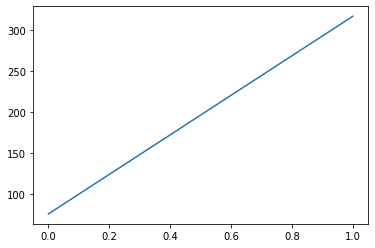

INFO:tensorflow:Assets written to: ./models/tf2_pg_cartpole/assets


In [8]:
from IPython.display import clear_output
rewards_log = []
max_reward = 0

try:
    for i in range(100):
        rewards = [myagent.train_on_session(*generate_session(myagent)) for _ in range(100)]  # generate new sessions
        rewards_log.append(np.mean(rewards))
        clear_output(True)
        print("mean reward: %.3f at iter:" % (np.mean(rewards)), i+1)
        plt.plot(rewards_log)
        plt.show()
        if rewards_log[i] > max_reward:
            max_reward = rewards_log[i]
            myagent.save()
        if np.mean(rewards) > 300:
            print("Yamerou!") 
            
except KeyboardInterrupt:
    clear_output(True)
    print("Stopped")
    print("mean reward: %.3f at iter:" % (np.mean(rewards)), i+1)
    plt.plot(rewards_log)
    plt.show()
    myagent.save()

In [ ]:
# Record sessions
import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    myagent.env = env_monitor
    sessions = [generate_session(myagent) for _ in range(100)]

In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices